# Data Loading & Preprocessing
Load ECG waveforms and apply preprocessing (filtering, normalization)

In [1]:
import pandas as pd
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

np.random.seed(42)

## 1. Load Split Metadata

In [2]:
# Load the split metadata
df_train = pd.read_csv('../data/train_metadata.csv')
df_val = pd.read_csv('../data/val_metadata.csv')
df_test = pd.read_csv('../data/test_metadata.csv')

print(f"Loaded splits:")
print(f"  Train: {len(df_train)} ECGs")
print(f"  Val: {len(df_val)} ECGs")
print(f"  Test: {len(df_test)} ECGs")

# PTB-XL base path
PTB_XL_PATH = '/scratch1/e20-fyp-ecg-ihd-detection/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
print(f"\nPTB-XL path: {PTB_XL_PATH}")

Loaded splits:
  Train: 5320 ECGs
  Val: 1136 ECGs
  Test: 1137 ECGs

PTB-XL path: /scratch1/e20-fyp-ecg-ihd-detection/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/


## 2. Define Preprocessing Functions

In [3]:
def load_ecg_signal(filename_lr, base_path):
    """
    Load ECG signal from .dat file using WFDB
    Args:
        filename_lr: Path like 'records100/00000/00001_lr'
        base_path: PTB-XL base directory
    Returns:
        signal: numpy array (1000, 12)
    """
    full_path = base_path + filename_lr
    record = wfdb.rdsamp(full_path)
    signal = record[0]  # (1000, 12)
    return signal

def remove_baseline_wander(signal, fs=100, cutoff=0.5):
    """
    High-pass filter to remove baseline wander
    Args:
        signal: (timesteps, leads)
        fs: sampling frequency (100 Hz for low-res)
        cutoff: high-pass cutoff frequency (0.5 Hz)
    Returns:
        filtered_signal: same shape as input
    """
    nyquist = fs / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(N=4, Wn=normal_cutoff, btype='high', analog=False)
    
    filtered_signal = np.zeros_like(signal)
    for lead_idx in range(signal.shape[1]):
        filtered_signal[:, lead_idx] = filtfilt(b, a, signal[:, lead_idx])
    
    return filtered_signal

def preprocess_ecg(signal):
    """
    Complete preprocessing pipeline
    1. Remove baseline wander
    2. Standardization will be done per-split after loading all data
    """
    signal_filtered = remove_baseline_wander(signal)
    return signal_filtered

print("✅ Preprocessing functions defined")

✅ Preprocessing functions defined


## 3. Load and Preprocess All ECGs

In [4]:
def load_dataset(df, base_path, split_name='train'):
    """
    Load all ECGs for a given split
    Returns:
        X: numpy array (n_samples, 1000, 12)
        y: numpy array (n_samples,)
    """
    n_samples = len(df)
    X = np.zeros((n_samples, 1000, 12), dtype=np.float32)
    y = df['label_ecg_binary'].values
    
    print(f"Loading {split_name} set: {n_samples} ECGs")
    
    for idx, row in tqdm(df.iterrows(), total=n_samples, desc=f"Loading {split_name}"):
        try:
            # Load signal
            signal = load_ecg_signal(row['filename_lr'], base_path)
            
            # Preprocess (remove baseline wander)
            signal_preprocessed = preprocess_ecg(signal)
            
            # Store
            X[df.index.get_loc(idx)] = signal_preprocessed
            
        except Exception as e:
            print(f"\nError loading ECG {row['ecg_id']}: {e}")
            # Fill with zeros if error (will be handled later)
            X[df.index.get_loc(idx)] = np.zeros((1000, 12))
    
    print(f"✅ Loaded {split_name}: X shape = {X.shape}, y shape = {y.shape}")
    return X, y

# Load all splits
X_train, y_train = load_dataset(df_train, PTB_XL_PATH, 'train')
X_val, y_val = load_dataset(df_val, PTB_XL_PATH, 'validation')
X_test, y_test = load_dataset(df_test, PTB_XL_PATH, 'test')

Loading train set: 5320 ECGs


Loading train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5320/5320 [00:13<00:00, 380.28it/s]


✅ Loaded train: X shape = (5320, 1000, 12), y shape = (5320,)
Loading validation set: 1136 ECGs


Loading validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:02<00:00, 378.98it/s]


✅ Loaded validation: X shape = (1136, 1000, 12), y shape = (1136,)
Loading test set: 1137 ECGs


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1137/1137 [00:02<00:00, 388.96it/s]

✅ Loaded test: X shape = (1137, 1000, 12), y shape = (1137,)


## 4. Standardization (Z-score per lead)

In [5]:
# Fit scaler on training data only
scaler = StandardScaler()

# Reshape for scaler: (n_samples * timesteps, n_leads)
X_train_flat = X_train.reshape(-1, 12)
scaler.fit(X_train_flat)

# Transform all splits
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, 12)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 12)).reshape(X_test.shape)

print("✅ Standardization complete")
print(f"\nScaler statistics (per lead):")
print(f"  Mean: {scaler.mean_}")
print(f"  Std: {scaler.scale_}")

✅ Standardization complete

Scaler statistics (per lead):
  Mean: [ 2.99936923e-05 -4.82990196e-05 -7.83032319e-05  9.53528143e-06
  5.40368618e-05 -6.34647981e-05 -2.39054305e-05 -9.87566389e-05
 -1.06824531e-04 -4.67365414e-05 -1.83863984e-05 -3.80453715e-05]
  Std: [0.13145823 0.14340867 0.11947571 0.12393135 0.10310558 0.11435078
 0.17128355 0.2803841  0.26949613 0.25098594 0.22249393 0.18421754]


## 5. Verify Preprocessing

In [6]:
# Check for NaN or Inf
print("Data quality check:")
print(f"  Train NaN: {np.isnan(X_train_scaled).sum()}")
print(f"  Train Inf: {np.isinf(X_train_scaled).sum()}")
print(f"  Val NaN: {np.isnan(X_val_scaled).sum()}")
print(f"  Test NaN: {np.isnan(X_test_scaled).sum()}")

# Check shapes
print(f"\nFinal shapes:")
print(f"  X_train: {X_train_scaled.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val_scaled.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test_scaled.shape}, y_test: {y_test.shape}")

# Check value ranges after standardization
print(f"\nValue ranges (should be centered around 0):")
print(f"  Train: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}], mean={X_train_scaled.mean():.4f}")
print(f"  Val: [{X_val_scaled.min():.2f}, {X_val_scaled.max():.2f}], mean={X_val_scaled.mean():.4f}")
print(f"  Test: [{X_test_scaled.min():.2f}, {X_test_scaled.max():.2f}], mean={X_test_scaled.mean():.4f}")

Data quality check:
  Train NaN: 0
  Train Inf: 0
  Val NaN: 0
  Test NaN: 0

Final shapes:
  X_train: (5320, 1000, 12), y_train: (5320,)
  X_val: (1136, 1000, 12), y_val: (1136,)
  X_test: (1137, 1000, 12), y_test: (1137,)

Value ranges (should be centered around 0):
  Train: [-67.28, 44.57], mean=-0.0000
  Val: [-39.26, 40.65], mean=-0.0003
  Test: [-28.02, 26.15], mean=-0.0000


## 6. Visualize Examples

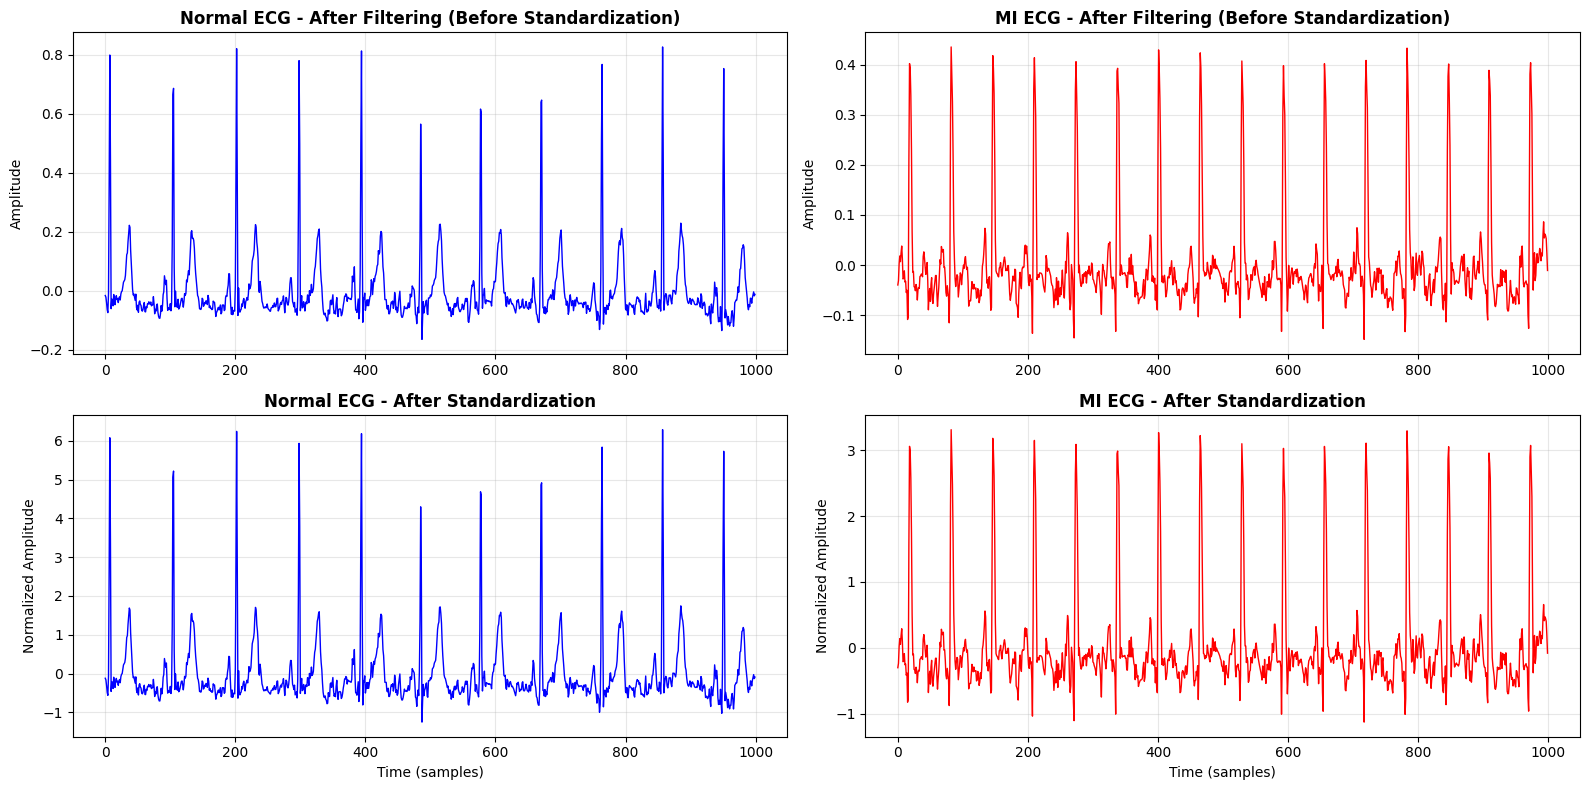

✅ Saved: preprocessing_comparison.png


In [7]:
# Plot comparison: Before and After preprocessing
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Get one Normal and one MI sample
normal_idx = np.where(y_train == 0)[0][0]
mi_idx = np.where(y_train == 1)[0][0]

lead_to_plot = 0  # Lead I

# Before standardization
axes[0, 0].plot(X_train[normal_idx, :, lead_to_plot], color='blue', linewidth=1)
axes[0, 0].set_title('Normal ECG - After Filtering (Before Standardization)', fontweight='bold')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(X_train[mi_idx, :, lead_to_plot], color='red', linewidth=1)
axes[0, 1].set_title('MI ECG - After Filtering (Before Standardization)', fontweight='bold')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].grid(True, alpha=0.3)

# After standardization
axes[1, 0].plot(X_train_scaled[normal_idx, :, lead_to_plot], color='blue', linewidth=1)
axes[1, 0].set_title('Normal ECG - After Standardization', fontweight='bold')
axes[1, 0].set_xlabel('Time (samples)')
axes[1, 0].set_ylabel('Normalized Amplitude')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(X_train_scaled[mi_idx, :, lead_to_plot], color='red', linewidth=1)
axes[1, 1].set_title('MI ECG - After Standardization', fontweight='bold')
axes[1, 1].set_xlabel('Time (samples)')
axes[1, 1].set_ylabel('Normalized Amplitude')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: preprocessing_comparison.png")

## 7. Save Preprocessed Data

In [8]:
# Save as numpy arrays
np.save('../data/X_train.npy', X_train_scaled)
np.save('../data/y_train.npy', y_train)

np.save('../data/X_val.npy', X_val_scaled)
np.save('../data/y_val.npy', y_val)

np.save('../data/X_test.npy', X_test_scaled)
np.save('../data/y_test.npy', y_test)

# Save scaler for future use
with open('../data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ All preprocessed data saved!")
print("\nFiles created:")
print("  • X_train.npy, y_train.npy")
print("  • X_val.npy, y_val.npy")
print("  • X_test.npy, y_test.npy")
print("  • scaler.pkl")

# File sizes
import os
print("\nFile sizes:")
for filename in ['X_train.npy', 'X_val.npy', 'X_test.npy']:
    size_mb = os.path.getsize(f'../data/{filename}') / (1024**2)
    print(f"  {filename}: {size_mb:.1f} MB")

✅ All preprocessed data saved!

Files created:
  • X_train.npy, y_train.npy
  • X_val.npy, y_val.npy
  • X_test.npy, y_test.npy
  • scaler.pkl

File sizes:
  X_train.npy: 243.5 MB
  X_val.npy: 52.0 MB
  X_test.npy: 52.0 MB


## 8. Summary

In [9]:
summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Samples': [len(X_train_scaled), len(X_val_scaled), len(X_test_scaled)],
    'Normal': [(y_train==0).sum(), (y_val==0).sum(), (y_test==0).sum()],
    'MI': [(y_train==1).sum(), (y_val==1).sum(), (y_test==1).sum()],
    'Shape': [str(X_train_scaled.shape), str(X_val_scaled.shape), str(X_test_scaled.shape)]
})

print("\n" + "="*70)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*70)
print(summary.to_string(index=False))
print("="*70)
print("\n✅ Ready for model training!")


PREPROCESSING COMPLETE - SUMMARY
     Split  Samples  Normal   MI            Shape
     Train     5320    4095 1225 (5320, 1000, 12)
Validation     1136     870  266 (1136, 1000, 12)
      Test     1137     883  254 (1137, 1000, 12)

✅ Ready for model training!
